# Backpropogation
- Training a network  (backpropagation) consists of:
  - Initializing weights at “random”.
  - Compute the network forward (forward pass)
  - Reduce loss by updating weights in opposite direction of gradient of the loss function.
  - Repeat the process until an optimized set of weights are calculated.

<img src="img/backprop.png" height="600" width="600">

# Gradient Descent
<img src="img/sgd2d.png" width="480" height="480">

# Loss Function
<img src="img/loss.png" height="480" width="480">

# Non-Convex Optimization
<img src="img/nonconvex.png" height="720" width="720">

# Training a network
- Define the network
- Initialize the network with with random/pre-trained weights
- Choose a loss function
- Choose an optimizer
- Prepare Dataset
- Run back propogation algorithm.
- Evaluate the output

In [1]:
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np
ctx = mx.gpu()

## Define the network

In [2]:
net = gluon.nn.Sequential()

with net.name_scope(): #Returns a name space object managing a child :py:class:`Block` and parameter names.
    net.add(gluon.nn.Dense(units=128, activation='relu'))
    net.add(gluon.nn.Dense(units=64, activation='relu'))
    net.add(gluon.nn.Dense(units=10))

## Initialize the network

In [3]:
net.initialize(mx.init.Xavier(magnitude=2.24), force_reinit=True, ctx=ctx)

## Choose a loss function

In [4]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

## Choose an Optimizer

In [5]:
trainer = gluon.Trainer(params=net.collect_params(), 
                        optimizer='sgd', 
                        optimizer_params={"learning_rate":0.01, "momentum": .9, "wd":.1})

## Prepare dataset

In [6]:
batch_size = 128
def transform(data, label):
    return (data.astype(np.float32)/255, label.astype(np.float32))

train_dataset = gluon.data.vision.MNIST(train=True, transform=transform)
val_dataset = gluon.data.vision.MNIST(train=False, transform=transform)

train_data_loader = gluon.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = gluon.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

(train_dataset[0][0].shape, train_dataset[0][1])


((28, 28, 1), 5.0)

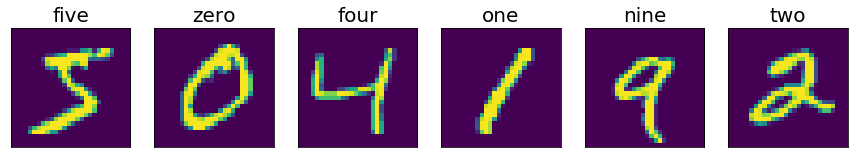

In [33]:
import matplotlib.pyplot as plt
text_labels = [
    'zero', 'one', 'two', 'three', 'four',
    'five', 'six', 'seven', 'eight', 'nine'
]
X, y = train_dataset[0:6]
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [8]:
X.shape

(6, 28, 28, 1)

In [9]:
(train_dataset[0][0].shape, train_dataset[0][1])

((28, 28, 1), 5.0)

In [10]:
for data, label in train_data_loader:
    print(data.shape, label.shape)
    break

(128, 28, 28, 1) (128,)


## Run back propogation algorithm

In [32]:
epochs = 1
for e in range(epochs):
    for i, (data, label) in enumerate(train_data_loader):
        with autograd.record():
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            outputs = net(data)
            loss = loss_fn(outputs, label)
        loss.backward()
        trainer.step(batch_size)
    print("EPOC: [{}]: ; train loss: {}".format(e, loss.mean().asscalar()))
        

EPOC: [0]: ; train loss: 0.8617481589317322


## Evaluate the Output
- In order to evaluate the putput we need to compare performance of the algorithm on training and evaluate

In [22]:
def evaluate_results(data_loader, network):
    acc = mx.metric.Accuracy()
    acc.reset()
    for i, (data, label) in enumerate(data_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        outputs = network(data)
        predictions = nd.argmax(outputs, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc


In [25]:
epochs = 5
for e in range(epochs):
    for i, (data, label) in enumerate(train_data_loader):
        with autograd.record():
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            outputs = net(data)
            loss = loss_fn(outputs, label)
        loss.backward()
        trainer.step(batch_size)
    train_acc = evaluate_results(train_data_loader, net).get()[1]
    val_acc = evaluate_results(val_data_loader, net).get()[1]
    print("EPOCH: [{}]: ; train loss: {}; train_acc: {}; val_acc: {}".format(e, loss.mean().asscalar(), train_acc, val_acc))

EPOC: [0]: ; train loss: 0.9534021019935608; train_acc: 0.7991333333333334; val_acc: 0.8055
EPOC: [1]: ; train loss: 0.9825796484947205; train_acc: 0.80535; val_acc: 0.8126
EPOC: [2]: ; train loss: 0.9855998158454895; train_acc: 0.8008833333333333; val_acc: 0.8102
EPOC: [3]: ; train loss: 1.0217260122299194; train_acc: 0.8086; val_acc: 0.8133
EPOC: [4]: ; train loss: 0.9908719062805176; train_acc: 0.8077; val_acc: 0.8151


# Challenge
- Try to rewrite the training code, using c conolutional network form the previous lab
- beware that `gluon.nn.Conv2d()` supports NCHW’ and ‘NHWC’ layout for now. ‘N’, ‘C’, ‘H’, ‘W’ stands for batch, channel, height, and width dimensions respectively. Convolution is applied on the ‘H’ and ‘W’ dimensions. 
- We need to use `nd.transpose()` in order to change the layout

In [31]:
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)

train_dataset_conv = gluon.data.vision.MNIST(train=True, transform=transform)
(("NEW: ", train_dataset_conv[0][0].shape, train_dataset_conv[0][1]),
("OLD: ", train_dataset[0][0].shape, train_dataset[0][1]))

(('NEW: ', (1, 28, 28), 5.0), ('OLD: ', (28, 28, 1), 5.0))